In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import janitor
import sklearn as sk
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
df = pd.read_csv('.\\survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
nulos_df = pd.DataFrame((df.isnull().sum() / len(df)),columns = ['Nulos']).sort_values(by = 'Nulos', ascending = False)
columnas_drop = list(nulos_df[nulos_df['Nulos'] > 0.8].reset_index()['index'])
df.drop(columnas_drop, axis = 1, inplace = True)

In [37]:
columnas = ['Salary','HoursPerWeek','Currency',
            'Methodology','WantWorkPlatform','EducationTypes','ImportantBenefits',
           'LearningNewTech','Gender','JobSatisfaction','CareerSatisfaction','YearsProgram',
           'MajorUndergrad','Country','University','EmploymentStatus','FormalEducation',
           'Professional','ProgramHobby','Respondent']
df[columnas].isnull().sum()

Salary                38501
HoursPerWeek          30792
Currency              29984
Methodology           25621
WantWorkPlatform      23508
EducationTypes        21038
ImportantBenefits     21157
LearningNewTech       20088
Gender                16345
JobSatisfaction       11016
CareerSatisfaction     8697
YearsProgram            247
MajorUndergrad         8551
Country                   0
University                0
EmploymentStatus          0
FormalEducation           0
Professional              0
ProgramHobby              0
Respondent                0
dtype: int64

In [38]:
df_f = df[columnas].copy(deep = True)

## Exploratory Data Analysis

In [39]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51392 entries, 0 to 51391
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Salary              12891 non-null  float64
 1   HoursPerWeek        20600 non-null  float64
 2   Currency            21408 non-null  object 
 3   Methodology         25771 non-null  object 
 4   WantWorkPlatform    27884 non-null  object 
 5   EducationTypes      30354 non-null  object 
 6   ImportantBenefits   30235 non-null  object 
 7   LearningNewTech     31304 non-null  object 
 8   Gender              35047 non-null  object 
 9   JobSatisfaction     40376 non-null  float64
 10  CareerSatisfaction  42695 non-null  float64
 11  YearsProgram        51145 non-null  object 
 12  MajorUndergrad      42841 non-null  object 
 13  Country             51392 non-null  object 
 14  University          51392 non-null  object 
 15  EmploymentStatus    51392 non-null  object 
 16  Form

In [45]:
pd.crosstab(index=df_f['Professional'],
            columns=df_f['EmploymentStatus'], margins=True).sort_values(by = 'All')

EmploymentStatus,Employed full-time,Employed part-time,I prefer not to say,"Independent contractor, freelancer, or self-employed","Not employed, and not looking for work","Not employed, but looking for work",Retired,All
Professional,,,,,,,,
None of these,278,72,90,120,219,115,20,914
Used to be a professional developer,580,41,14,116,53,97,82,983
Professional non-developer who sometimes writes code,3815,388,86,559,86,190,16,5140
Student,1264,1255,704,747,2310,1919,25,8224
Professional developer,30211,1424,192,3691,123,465,25,36131
All,36148,3180,1086,5233,2791,2786,168,51392


In [46]:
pd.crosstab(index=df_f['FormalEducation'],
            columns=df_f['EmploymentStatus'], margins=True).sort_values(by = 'All')

EmploymentStatus,Employed full-time,Employed part-time,I prefer not to say,"Independent contractor, freelancer, or self-employed","Not employed, and not looking for work","Not employed, but looking for work",Retired,All
FormalEducation,,,,,,,,
I never completed any formal education,232,18,21,67,56,23,9,426
Professional degree,533,33,10,91,11,28,9,715
Primary/elementary school,162,82,75,129,482,107,10,1047
I prefer not to answer,314,60,355,122,182,68,8,1109
Doctoral degree,1103,35,13,109,10,16,22,1308
Secondary school,2121,784,260,747,1215,770,11,5908
Some college/university study without earning a bachelor's degree,5184,790,109,1051,381,584,30,8129
Master's degree,9206,338,76,1099,98,291,33,11141
Bachelor's degree,17293,1040,167,1818,356,899,36,21609


In [47]:
pd.crosstab(index=df_f['FormalEducation'],
            columns=df_f['Professional'], margins=True).sort_values(by = 'All')

Professional,None of these,Professional developer,Professional non-developer who sometimes writes code,Student,Used to be a professional developer,All
FormalEducation,,,,,,
I never completed any formal education,28,261,36,91,10,426
Professional degree,13,543,83,59,17,715
Primary/elementary school,115,204,58,660,10,1047
I prefer not to answer,80,389,79,545,16,1109
Doctoral degree,39,791,395,38,45,1308
Secondary school,194,2280,415,2971,48,5908
Some college/university study without earning a bachelor's degree,140,5390,821,1634,144,8129
Master's degree,102,8983,1323,432,301,11141
Bachelor's degree,203,17290,1930,1794,392,21609


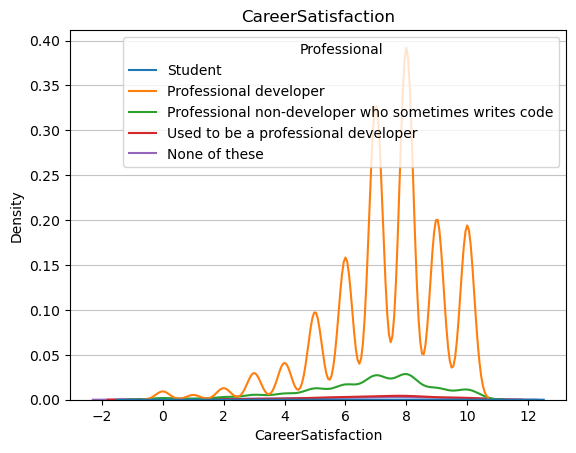

In [136]:

p15,p85 = np.percentile(df['CareerSatisfaction'],[2.5, 97.5])

sns.kdeplot( data = df,
             x = 'CareerSatisfaction' ,
#              label="JobSatisfaction", 
             hue = 'Professional').set(title='CareerSatisfaction')

# plt.xlim(p15,p85)
# plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_1644\1212186912.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot( data = df,


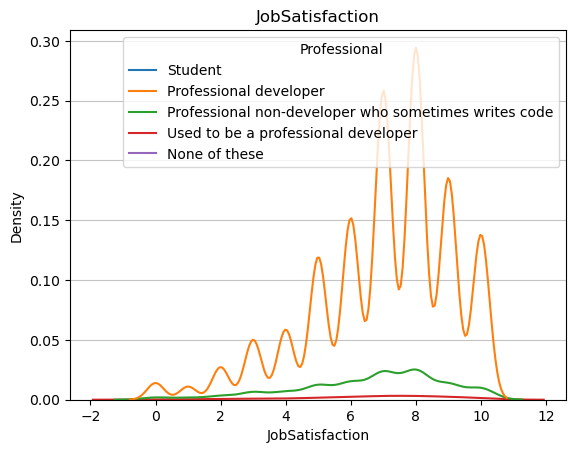

In [137]:
p15,p85 = np.percentile(df['JobSatisfaction'],[2.5, 97.5])

sns.kdeplot( data = df,
             x = 'JobSatisfaction' ,
#              label="JobSatisfaction", 
             hue = 'Professional').set(title='JobSatisfaction')

# plt.xlim(p15,p85)
# plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [53]:
df_f['ProgramHobby'].value_counts()

Yes, I program as a hobby                    24801
Yes, both                                    13756
No                                            9787
Yes, I contribute to open source projects     3048
Name: ProgramHobby, dtype: int64

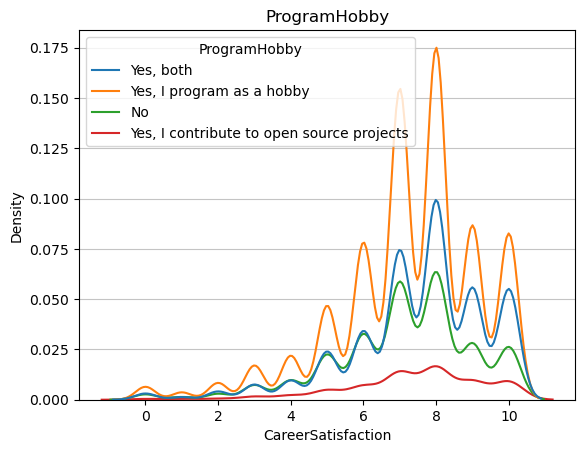

In [134]:
p15,p85 = np.percentile(df['JobSatisfaction'],[2.5, 97.5])

sns.kdeplot( data = df,
             x = 'CareerSatisfaction' ,
#              label="JobSatisfaction", 
             hue = 'ProgramHobby' ).set(title='ProgramHobby')

# plt.xlim(p15,p85)
# plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [61]:
df_f['YearsProgramNew'] = df_f['YearsProgram'].replace({
'Less than a year': 'less than 2 years',
'1 to 2 years': 'less than 2 years',
'2 to 3 years': 'less than 7 years',
'3 to 4 years': 'less than 7 years',
'4 to 5 years': 'less than 7 years',
'5 to 6 years': 'less than 7 years',
'6 to 7 years': 'less than 7 years',
'7 to 8 years': 'less than 12 years',
'8 to 9 years': 'less than 12 years',
'9 to 10 years': 'less than 12 years',
'10 to 11 years': 'less than 12 years',
'11 to 12 years' : 'less than 12 years',
'12 to 13 years': 'less than 17 years',
'13 to 14 years': 'less than 17 years',
'14 to 15 years': 'less than 17 years',
'15 to 16 years': 'less than 17 years',
'16 to 17 years': 'less than 17 years',
'17 to 18 years': 'less than 20 years',
'18 to 19 years': 'less than 20 years',
'19 to 20 years': 'less than 20 years',
'20 or more years':  '20 or more years'
})

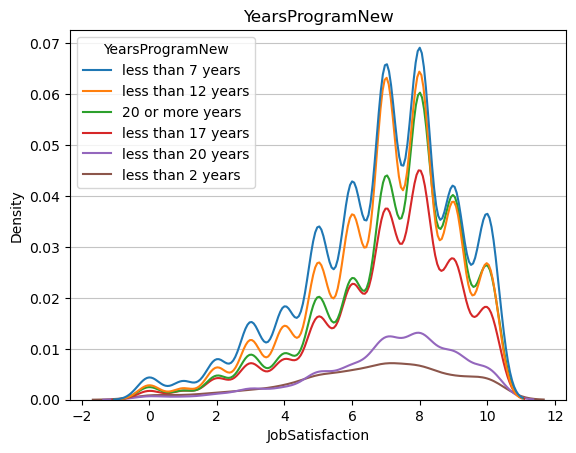

In [133]:
p15,p85 = np.percentile(df['JobSatisfaction'],[2.5, 97.5])

sns.kdeplot( data = df_f,
             x = 'JobSatisfaction' ,
#              label="JobSatisfaction", 
             hue = 'YearsProgramNew' ).set(title='YearsProgramNew')

# plt.xlim(p15,p85)
# plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [67]:
pd.DataFrame(df_f['EducationTypes'].value_counts()).sort_values(by='EducationTypes',ascending = False).head(10)

,EducationTypes
Self-taught,3691
Online course; Self-taught,1875
Self-taught; Open source contributions,1751
On-the-job training; Self-taught,1687
Online course; On-the-job training; Self-taught,1276
Online course; Self-taught; Open source contributions,856
On-the-job training; Self-taught; Open source contributions,780
Self-taught; Hackathon; Open source contributions,521
Online course; On-the-job training; Self-taught; Open source contributions,496
Online course; Self-taught; Coding competition,479


In [68]:
pd.DataFrame(df_f['ImportantBenefits'].value_counts()).sort_values(by='ImportantBenefits',ascending = False).head(10)

,ImportantBenefits
None of these,653
Retirement; Vacation/days off; Health benefits; Expected work hours; Remote options,363
Vacation/days off; Equipment; Professional development sponsorship; Expected work hours; Remote options,324
Vacation/days off; Health benefits; Equipment; Expected work hours; Remote options,305
Vacation/days off; Health benefits; Professional development sponsorship; Expected work hours; Remote options,249
Annual bonus; Vacation/days off; Health benefits; Expected work hours; Remote options,209
Remote options,197
Vacation/days off; Expected work hours; Remote options,182
Vacation/days off; Health benefits; Equipment; Professional development sponsorship; Remote options,179
Retirement; Annual bonus; Vacation/days off; Health benefits; Remote options,178


## Business Understanding
1. Does being doctor improve the salary?
2. Is there a difference between proffessional developers who are self-taught and those who learn in other ways in the Salarys?
3. Do remote work benefits infuence job satisfaction?

In [92]:
doctoral = df_f[(df_f['FormalEducation'] == 'Doctoral degree') & (~df_f['Salary'].isnull())]
non_doctoral = df_f[(df_f['FormalEducation'] != 'Doctoral degree') & (~df_f['Salary'].isnull())]

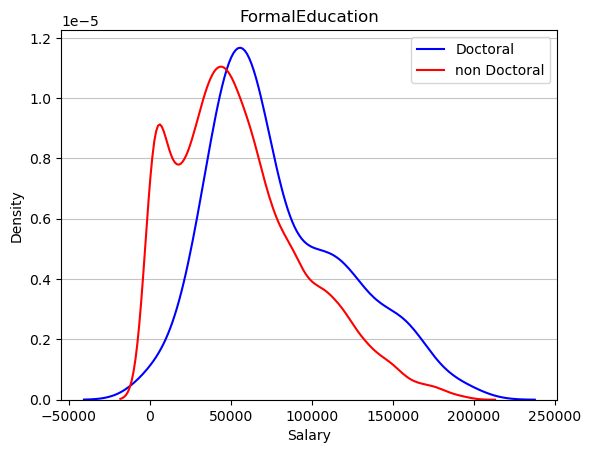

In [132]:
p15,p85 = np.percentile(df['JobSatisfaction'],[2.5, 97.5])

sns.kdeplot( data = doctoral,
             x = 'Salary' ,
             color = 'blue',
             label = "Doctoral").set(title='FormalEducation')

sns.kdeplot( data = non_doctoral,
             x = 'Salary' ,
             color = 'red',
             label="non Doctoral")

# plt.xlim(p15,p85)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [97]:
doctoral['Salary'].describe(), non_doctoral['Salary'].describe()

(count       293.000000
 mean      78527.933053
 std       42079.192733
 min          45.161290
 25%       48387.096774
 50%       64516.129032
 75%      107526.881720
 max      197000.000000
 Name: Salary, dtype: float64,
 count     12598.000000
 mean      55781.475596
 std       39682.181044
 min           0.000000
 25%       25806.451613
 50%       50000.000000
 75%       80000.000000
 max      195000.000000
 Name: Salary, dtype: float64)

there is a difference between the respondents with a doctorate and without a doctorate in terms of salary, this difference is conclusive to affirm that the salary is higher than the respondent who has a doctorate. also it suggest that the salary of respondent who has a doctorate is unlikely lower

In [116]:
df_f['Self-taught'] = df_f['EducationTypes'].apply(lambda x: 'Self-taught' if 'Self-taught' in str(x) else 'other')

In [125]:
self_taught = df_f[(df_f['Self-taught'] == 'Self-taught') & 
                   (~df_f['Salary'].isnull()) ]
non_self_taught = df_f[
                        (df_f['Self-taught'] == 'other') & 
                       (~df_f['Salary'].isnull()) &
                       (~df_f['EducationTypes'].isnull())
                      ]

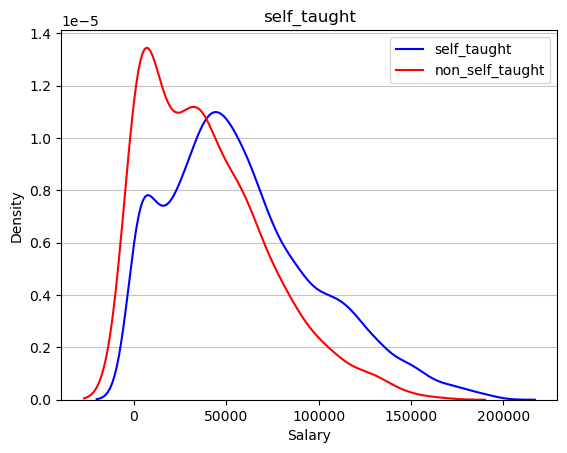

In [131]:
p15,p85 = np.percentile(df['JobSatisfaction'],[2.5, 97.5])

sns.kdeplot( data = self_taught,
             x = 'Salary' ,
             color = 'blue',
             label = "self_taught").set(title='self_taught')

sns.kdeplot( data = non_self_taught,
             x = 'Salary' ,
             color = 'red',
             label="non_self_taught")

# plt.xlim(p15,p85)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [128]:
non_self_taught.Salary.describe(), self_taught.Salary.describe()

(count       682.000000
 mean      39286.095873
 std       33025.489961
 min           0.000000
 25%       10288.764380
 50%       34077.712610
 75%       59316.196237
 max      163134.796652
 Name: Salary, dtype: float64,
 count      8194.000000
 mean      58531.526886
 std       40339.113666
 min           0.000000
 25%       28750.000000
 50%       52000.000000
 75%       82556.818182
 max      197000.000000
 Name: Salary, dtype: float64)

people who are self-taught have bigger salary than who are not self-taught, probability distributions suggest that is likely you have a big salary if you was self-taught 

In [142]:
df_f['remote'] = df_f['ImportantBenefits'].apply(lambda x: 'Remote' if 'Remote options' in str(x) else 'other')

In [149]:
remote = df_f[(df_f['remote'] == 'Remote') & (~df_f['JobSatisfaction'].isnull())]
non_remote = df_f[(df_f['remote'] == 'other') & (~df_f['JobSatisfaction'].isnull()) &
                    (~df_f['ImportantBenefits'].isnull())
                   ]

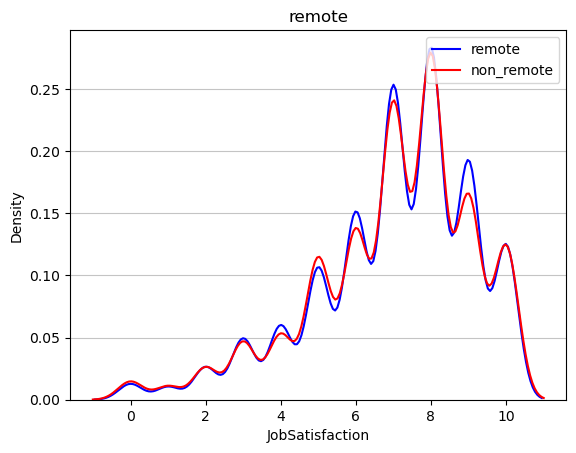

In [152]:

sns.kdeplot( data = remote,
             x = 'JobSatisfaction' ,
             color = 'blue',
             label = "remote").set(title='remote')

sns.kdeplot( data = non_remote,
             x = 'JobSatisfaction' ,
             color = 'red',
             label="non_remote")

# plt.xlim(p15,p85)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

there is no difference in job satisfaction if a respondent prefers remote work or not

## Treatment: Impute / Drop nulls, Handle Categorical

In [155]:
df_f.dropna(subset = ['Salary'], inplace = True)

In [158]:
(df_f.isna().sum() / len(df_f)).sort_values()

Salary                0.000000
Respondent            0.000000
ProgramHobby          0.000000
Professional          0.000000
FormalEducation       0.000000
EmploymentStatus      0.000000
University            0.000000
Country               0.000000
Self-taught           0.000000
remote                0.000000
YearsProgramNew       0.000931
YearsProgram          0.000931
CareerSatisfaction    0.002327
JobSatisfaction       0.003025
Currency              0.069739
MajorUndergrad        0.071911
Gender                0.091692
WantWorkPlatform      0.271740
ImportantBenefits     0.303545
LearningNewTech       0.311380
EducationTypes        0.311458
Methodology           0.366845
HoursPerWeek          0.558995
dtype: float64

In [171]:
impute_jobsatisfaction = df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','JobSatisfaction']]

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_1644\3419348436.py:1: FutureWarning: The operation <function mean at 0x00000259CBCA9700> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  impute_jobsatisfaction = df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','JobSatisfaction']]


In [183]:
b = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Bachelor's degree"].JobSatisfaction.values
d = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Doctoral degree"].JobSatisfaction.values
f_i = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "I never completed any formal education"].JobSatisfaction.values
n_a = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "I prefer not to answer"].JobSatisfaction.values
m_d = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Master's degree"].JobSatisfaction.values
p_s = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Primary/elementary school"].JobSatisfaction.values
p_d = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Professional degree"].JobSatisfaction.values
s_s = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Secondary school"].JobSatisfaction.values
s_co = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Some college/university study without earning a bachelor's degree"].JobSatisfaction.values

In [208]:
df_f[(df_f['FormalEducation'] == "Bachelor's degree")] = df_f[(df_f['FormalEducation'] == "Bachelor's degree")].fillna( value = {'JobSatisfaction':  round(b[0])})
df_f[(df_f['FormalEducation'] == "Doctoral degree")] = df_f[(df_f['FormalEducation'] == "Doctoral degree")].fillna( value = {'JobSatisfaction':  round(d[0])})
df_f[(df_f['FormalEducation'] == "I never completed any formal education")] = df_f[(df_f['FormalEducation'] == "I never completed any formal education")].fillna( value = {'JobSatisfaction':  round(f_i[0])})
df_f[(df_f['FormalEducation'] == "I prefer not to answer")] = df_f[(df_f['FormalEducation'] == "I prefer not to answer")].fillna( value = {'JobSatisfaction':  round(n_a[0])})
df_f[(df_f['FormalEducation'] == "Master's degree")] = df_f[(df_f['FormalEducation'] == "Master's degree")].fillna( value = {'JobSatisfaction':  round(m_d[0])})
df_f[(df_f['FormalEducation'] == "Primary/elementary school")] = df_f[(df_f['FormalEducation'] == "Primary/elementary school")].fillna( value = {'JobSatisfaction':  round(p_s[0])})
df_f[(df_f['FormalEducation'] == "Professional degree")] = df_f[(df_f['FormalEducation'] == "Professional degree")].fillna( value = {'JobSatisfaction':  round(p_d[0])})
df_f[(df_f['FormalEducation'] == "Secondary school")] = df_f[(df_f['FormalEducation'] == "Secondary school")].fillna( value = {'JobSatisfaction':  round(s_s[0])})
df_f[(df_f['FormalEducation'] == "Some college/university study without earning a bachelor's degree")] = df_f[(df_f['FormalEducation'] == "Some college/university study without earning a bachelor's degree")].fillna( value = {'JobSatisfaction':  round(s_co[0])})

In [256]:
df_f = df_f[(df_f['Salary'] > 0)]
X = df_f[['ProgramHobby','Professional',
      'FormalEducation','EmploymentStatus', 'JobSatisfaction'
         ]]

y = df_f['Salary'].agg(np.log1p)

9082      0.014575
23414     0.028941
29459     0.043104
30627     0.043104
9133      0.043104
           ...    
41398    12.180760
18237    12.180760
27943    12.180760
1696     12.180760
31600    12.190964
Name: Salary, Length: 12885, dtype: float64

In [257]:
X = pd.get_dummies(X)

# Modeling

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [259]:
reg = xgb.XGBRegressor(verbosity=0) 

In [260]:
%time reg.fit(X_train, y_train)

CPU times: total: 2.17 s
Wall time: 299 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [261]:
score = reg.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.08972806112945242
